# **Data Analysis and Visualization**

In this section, the results obtained in "model_run" will be analyzed and visualized.

In [69]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


**Upload Necessary Data**

In [83]:
# upload the data with the following code
model_dataframe_initial = pd.read_csv(f"../result_1/{'model_results_no_subsidy'}.csv")

model_dataframe_income_threshold = pd.read_csv(f"../result_1/{'model_sensitivity_results_income_threshold'}.csv")
model_dataframe_saving_threshold = pd.read_csv(f"../result_1/{'model_sensitivity_results_saving_threshold'}.csv")
model_dataframe_subsidy_rate = pd.read_csv(f"../result_1/{'model_sensitivity_results_subsidy_rate'}.csv")
model_dataframe_flood_prob = pd.read_csv(f"../result_1/{'model_sensitivity_results_flood_prob'}.csv")


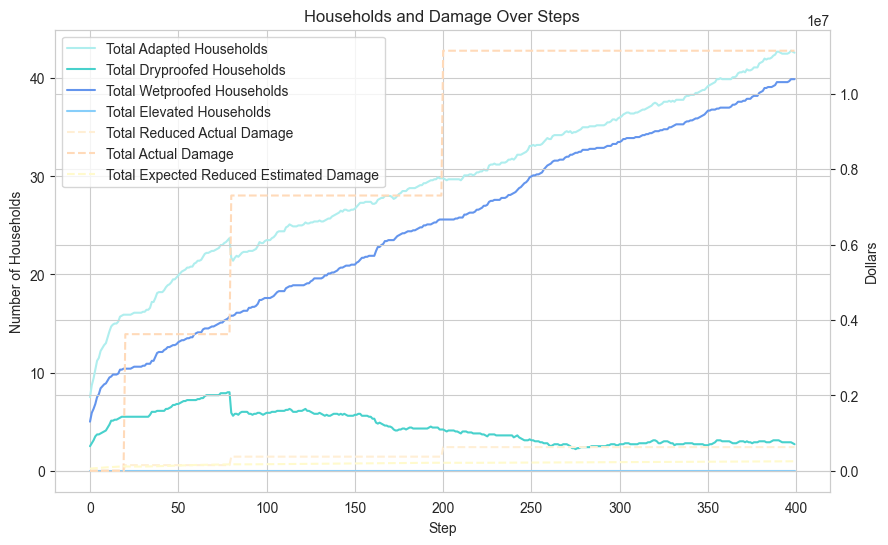

In [67]:

grouped_data = model_dataframe_initial.groupby('Step').agg('mean').reset_index()
# Define warm and cold colors
warm_colors = ['PapayaWhip', 'PeachPuff', 'LemonChiffon']
cold_colors = ['PaleTurquoise', 'MediumTurquoise', 'CornflowerBlue', 'LightSkyBlue']

# Create the line chart with dual Y-axes and custom colors
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Lines on the left Y-axis (number of households) with cold colors
ax1.plot(grouped_data['Step'], grouped_data['total_adapted_households'], label='Total Adapted Households', linestyle='-', color=cold_colors[0])
ax1.plot(grouped_data['Step'], grouped_data['total_dryproofed_households'], label='Total Dryproofed Households', linestyle='-', color=cold_colors[1])
ax1.plot(grouped_data['Step'], grouped_data['total_wetproofed_households'], label='Total Wetproofed Households', linestyle='-', color=cold_colors[2])
ax1.plot(grouped_data['Step'], grouped_data['total_elevated_households'], label='Total Elevated Households', linestyle='-', color=cold_colors[3])

# Lines on the right Y-axis (in dollars) with warm colors
ax2.plot(grouped_data['Step'], grouped_data['total_reduced_actual_damage'], label='Total Reduced Actual Damage', linestyle='--', color=warm_colors[0])
ax2.plot(grouped_data['Step'], grouped_data['total_actual_damage'], label='Total Actual Damage', linestyle='--', color=warm_colors[1])
ax2.plot(grouped_data['Step'], grouped_data['total_expected_reduced_estimated_damage'], label='Total Expected Reduced Estimated Damage', linestyle='--', color=warm_colors[2])

# Add labels and title
ax1.set_xlabel('Step')
ax1.set_ylabel('Number of Households')
ax2.set_ylabel('Dollars')
plt.title('Households and Damage Over Steps')

# Show the legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
plt.legend(lines, labels)

# Show the grid
ax1.grid(True)

# Display the chart
plt.show()

KeyError: 'total_subsidy'

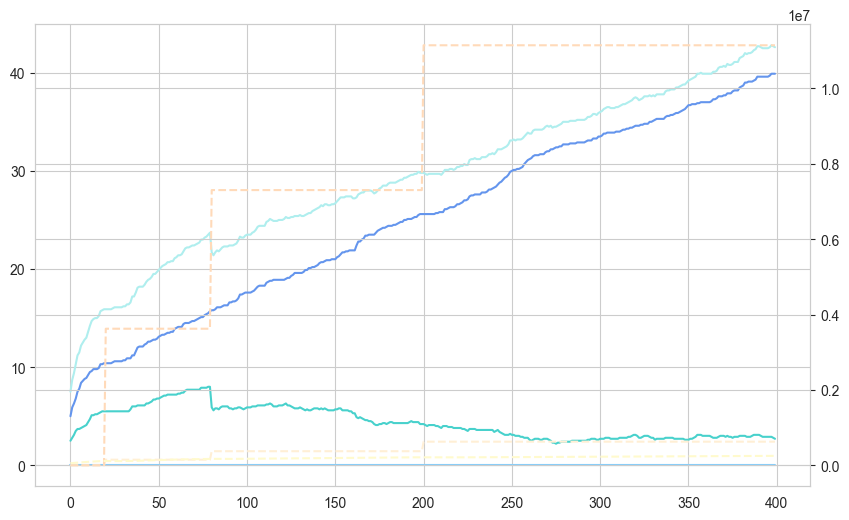

In [81]:

def create_dual_axis_line_chart(dataframe, left_y_data, right_y_data, warm_colors, cold_colors, title):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot data for the left Y-axis
    for index, (column, label) in enumerate(left_y_data):
        ax1.plot(dataframe['Step'], dataframe[column], label=label, linestyle='-', color=cold_colors[index])

    # Plot data for the right Y-axis
    for index, (column, label) in enumerate(right_y_data):
        ax2.plot(dataframe['Step'], dataframe[column], label=label, linestyle='--', color=warm_colors[index])

    # Add labels and title
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Number of Households')
    ax2.set_ylabel('Dollars')
    plt.title(title)

    # Show the legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    plt.legend(lines, labels)

    # Show the grid and display the chart
    ax1.grid(True)
    plt.show()

# Define warm and cold colors
warm_colors = ['PapayaWhip', 'PeachPuff', 'LemonChiffon', 'Pink']
cold_colors = ['PaleTurquoise', 'MediumTurquoise', 'CornflowerBlue', 'LightSkyBlue']

# Define data for each axis
left_y_data = [
    ('total_adapted_households', 'Total Adapted Households'),
    ('total_dryproofed_households', 'Total Dryproofed Households'),
    ('total_wetproofed_households', 'Total Wetproofed Households'),
    ('total_elevated_households', 'Total Elevated Households')
]

right_y_data = [
    ('total_reduced_actual_damage', 'Total Reduced Actual Damage'),
    ('total_actual_damage', 'Total Actual Damage'),
    ('total_expected_reduced_estimated_damage', 'Total Expected Reduced Estimated Damage'),
    ('total_subsidy', 'Total Subsidy')
]

# Prepare your dataframe
grouped_data = model_dataframe_initial.groupby('Step').agg('mean').reset_index()

# Call the function to create the plot
create_dual_axis_line_chart(grouped_data, left_y_data, right_y_data, warm_colors, cold_colors, 'Households and Damage Over Steps')

In [33]:
def load_and_filter_dataframe(file_path, step=399):
    df = pd.read_csv(file_path)
    return df[df['Step'] == step]

def calculate_statistics(dataframe, column_name, parameter_name, parameter_values):
    results = {}
    for value in parameter_values:
        filtered_df = dataframe[dataframe[parameter_name] == value]
        mean_val = filtered_df[column_name].mean()
        max_val = filtered_df[column_name].max()
        min_val = filtered_df[column_name].min()
        results[value] = [mean_val, max_val, min_val]
    return results

# Define the file paths and parameters
file_paths = {
    "income_threshold": "../result_1/model_sensitivity_results_income_threshold.csv",
    "saving_threshold": "../result_1/model_sensitivity_results_saving_threshold.csv",
    "subsidy_rate": "../result_1/model_sensitivity_results_subsidy_rate.csv",
    "flood_prob": "../result_1/model_sensitivity_results_flood_prob.csv"
}

parameter_column_names = {
    "income_threshold": "income_threshold",
    "saving_threshold": "rate",
    "subsidy_rate": "subsidy_rate",
    "flood_prob": "flood_probability"
}

parameters = {
    "income_threshold": [3600, 4000, 4400],
    "saving_threshold": [0.45, 0.5, 0.55],
    "subsidy_rate": [0.45, 0.5, 0.55],
    "flood_prob": [0.063, 0.07, 0.077]
}

# **Single Parameter Sensitivity Analysis**

{'income_threshold': {3600: [41.2, 52, 32], 4000: [42.6, 53, 35], 4400: [43.6, 53, 36]}, 'saving_threshold': {0.45: [52.1, 64, 44], 0.5: [42.6, 53, 35], 0.55: [34.4, 46, 27]}, 'subsidy_rate': {0.45: [41.5, 52, 32], 0.5: [42.6, 53, 35], 0.55: [43.2, 55, 35]}, 'flood_prob': {0.063: [36.9, 45, 29], 0.07: [42.6, 53, 35], 0.077: [47.9, 61, 37]}}


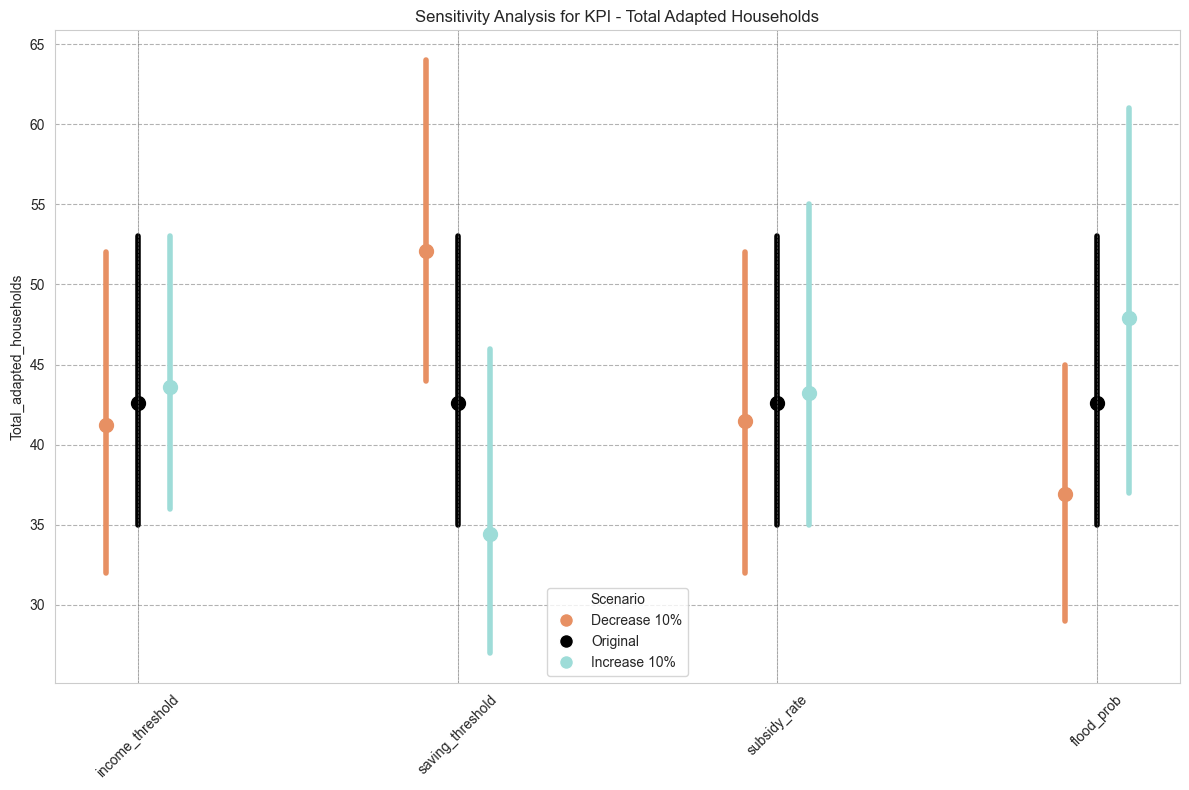

In [78]:

# Initialize a dictionary to store all results
data_TAH = {}

# Loop through each DataFrame and calculate statistics
for key, file_path in file_paths.items():
    df = load_and_filter_dataframe(file_path)
    parameter_name = parameter_column_names[key]
    statistics = calculate_statistics(df, 'total_adapted_households', parameter_name, parameters[key])
    data_TAH[key] = statistics

# Now 'data_TAH' contains all the results in the desired format
print(data_TAH)

# Define new colors and labels
colors = ['#e79063', 'black', '#9edcd8']  # Colors for decrease 10%, original, and increase 10% respectively
scenario_labels = ['Decrease 10%', 'Original', 'Increase 10%']

# Create the dot-whisker chart
fig, ax = plt.subplots(figsize=(12, 8))
offset = 0.1  # Offset for scenarios from the central axis
whisker_width = 4  # Width of the whisker lines

# Plot each set of points with a different color and slightly offset on the X axis
for i, (variable, scenarios) in enumerate(data_TAH.items()):
    position = i  # Central position for the group of scenarios for each variable
    for j, (level, values) in enumerate(scenarios.items()):
        scenario_offset = (j - 1) * offset
        median_value = np.median(values)
        min_value = np.min(values)
        max_value = np.max(values)
        
        # Draw the whisker line
        ax.plot([position + scenario_offset] * 2, [min_value, max_value], '-', color=colors[j], linewidth=whisker_width)
        
        # Draw the median dot
        ax.plot(position + scenario_offset, median_value, 'o', color=colors[j], markersize=10)

# Group lines visually with vertical lines or shading
for i in range(len(data_TAH)):
    ax.axvline(x=i, color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

# Set the labels for the x-ticks and position them
ax.set_xticks(range(len(data_TAH)))
ax.set_xticklabels([variable for variable in data_TAH.keys()], rotation=45)

# Set the axis labels and title
ax.set_ylabel('Total_adapted_households')
ax.set_title('Sensitivity Analysis for KPI - Total Adapted Households')

# Add a custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, scenario_labels)]
ax.legend(handles=legend_elements, title='Scenario')

# Grid and layout settings
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


# **Multiple Parameter Sensitivity Analysis**

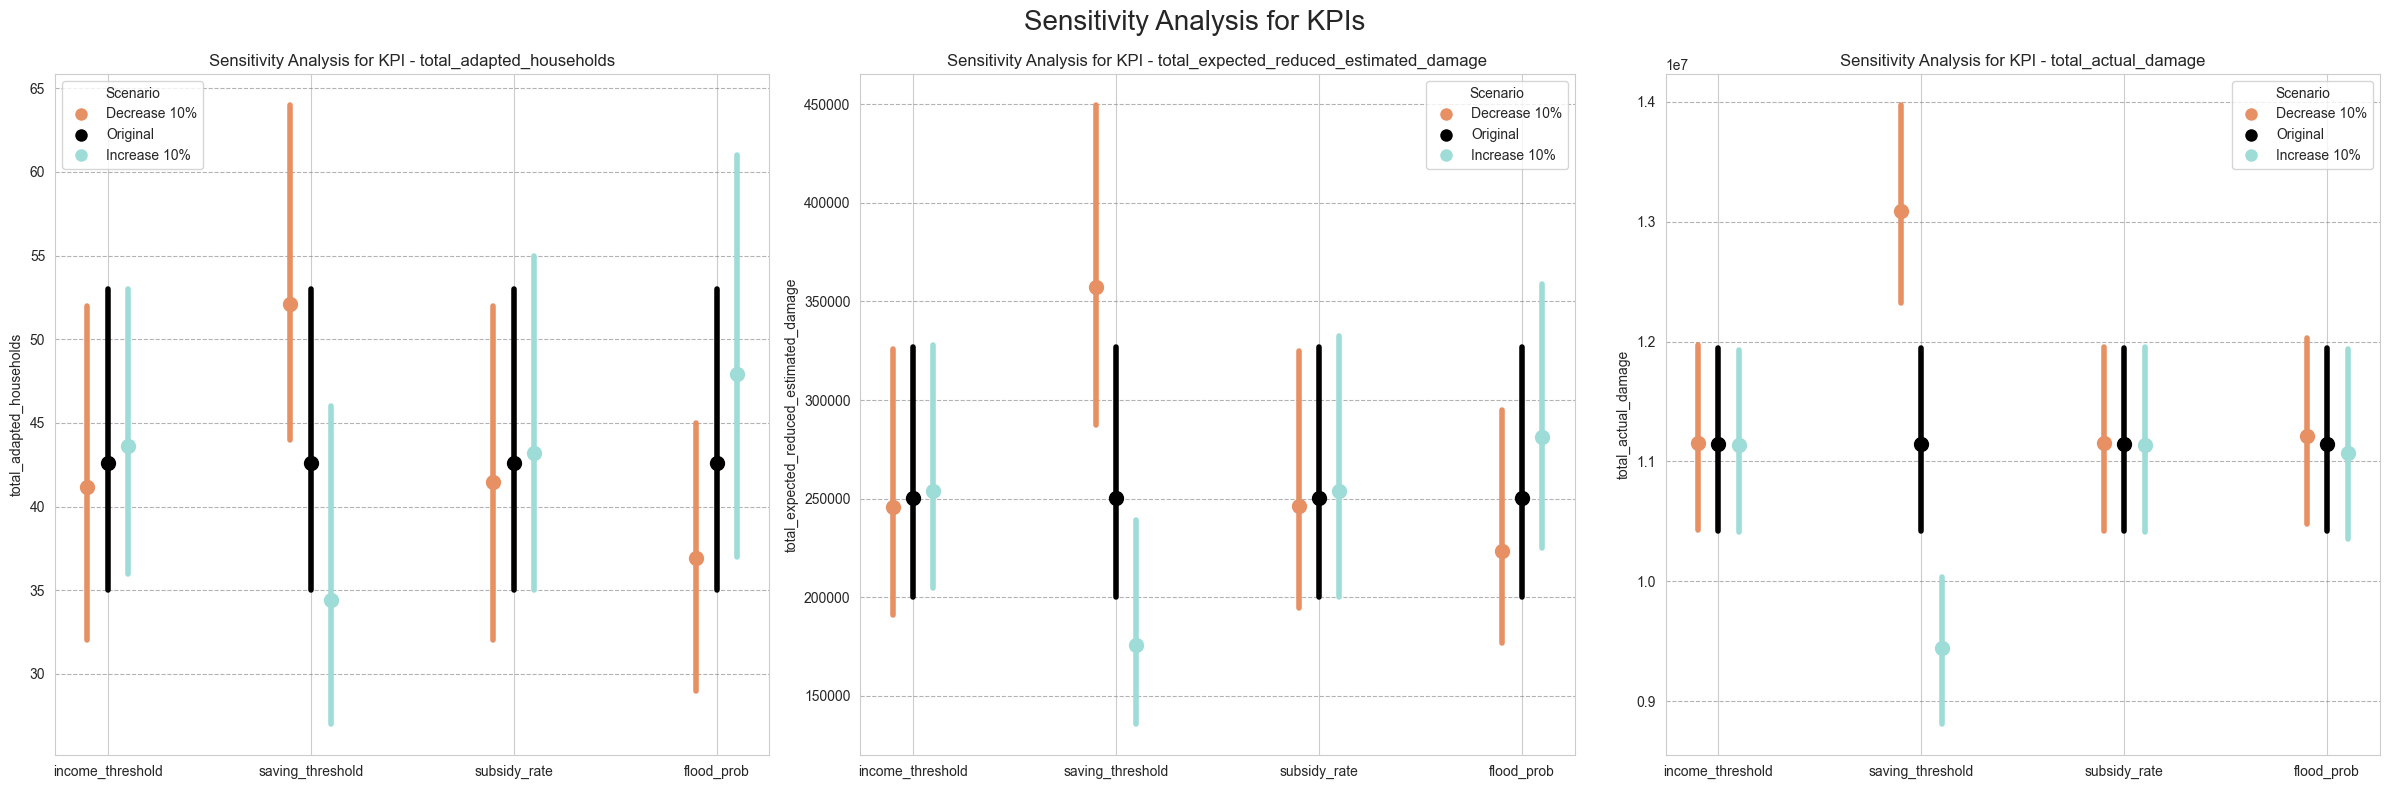

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Assuming 'load_and_filter_dataframe' and 'calculate_statistics' are predefined functions
# and 'file_paths', 'parameter_column_names', 'parameters' are already defined.

# Define the list of KPIs you want to analyze
kpis = ['total_adapted_households', 'total_expected_reduced_estimated_damage', 'total_actual_damage']  # Replace 'kpi2', 'kpi3', etc., with actual KPI names

# Define the number of rows and columns for the subplots
num_rows = 1  # Set the desired number of rows
num_cols = 3  # Set the desired number of columns

# Create a figure with the defined number of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 8 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Initialize a dictionary to store all results for each KPI
data_kpis = {kpi: {} for kpi in kpis}

# Loop through each DataFrame and calculate statistics for each KPI
for kpi in kpis:
    for key, file_path in file_paths.items():
        df = load_and_filter_dataframe(file_path)
        parameter_name = parameter_column_names[key]
        statistics = calculate_statistics(df, kpi, parameter_name, parameters[key])
        data_kpis[kpi][key] = statistics

# Define new colors and labels for the graph
colors = ['#e79063', 'black', '#9edcd8']
scenario_labels = ['Decrease 10%', 'Original', 'Increase 10%']

# Plot each set of points for each KPI
for ax, (kpi, data_kpi) in zip(axes, data_kpis.items()):
    offset = 0.1  # Offset for scenarios from the central axis
    whisker_width = 4  # Width of the whisker lines

    for i, (variable, scenarios) in enumerate(data_kpi.items()):
        position = i
        for j, (level, values) in enumerate(scenarios.items()):
            scenario_offset = (j - 1) * offset
            median_value = np.median(values)
            min_value = np.min(values)
            max_value = np.max(values)

            # Draw the whisker line and median dot
            ax.plot([position + scenario_offset] * 2, [min_value, max_value], '-', color=colors[j], linewidth=whisker_width)
            ax.plot(position + scenario_offset, median_value, 'o', color=colors[j], markersize=10)

    # Set the labels for the x-ticks
    ax.set_xticks(range(len(data_kpi)))
    ax.set_xticklabels([variable for variable in data_kpi.keys()], rotation=0)

    # Set the axis labels and title
    ax.set_ylabel(kpi)
    ax.set_title(f'Sensitivity Analysis for KPI - {kpi}')

    # Add a custom legend and grid
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, scenario_labels)]
    ax.legend(handles=legend_elements, title='Scenario')
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

# Hide any unused subplots
for i in range(len(data_kpis), len(axes)):
    axes[i].set_visible(False)

# Set the title for the entire figure
fig.suptitle('Sensitivity Analysis for KPIs', fontsize=20)

plt.tight_layout()
fig.subplots_adjust(top=0.9) # Adjust the top spacing to accommodate the figure title
plt.show()
